## Flight fare prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import warnings
from prettytable import PrettyTable
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

In [539]:
data=pd.read_excel("Data_Train.xlsx")

In [540]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [541]:
data["Source"].value_counts()

Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [542]:
data["Destination"].value_counts()

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [543]:
indexNames = data[data['Destination'] == "New Delhi" ].index

data.drop(indexNames , inplace=True)

In [544]:
data["Airline"].value_counts()

Jet Airways                          3431
IndiGo                               1896
Air India                            1540
Multiple carriers                    1196
SpiceJet                              774
Vistara                               425
Air Asia                              301
GoAir                                 170
Multiple carriers Premium economy      13
Jet Airways Business                    2
Vistara Premium economy                 2
Trujet                                  1
Name: Airline, dtype: int64

In [545]:
data.shape

(9751, 11)

In [546]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [547]:
data["Route"].isnull().values.any()

True

In [548]:
data["Total_Stops"].isnull().values.any()

True

In [549]:
data.dropna(inplace=True)

In [550]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [551]:
data.shape

(9750, 11)

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

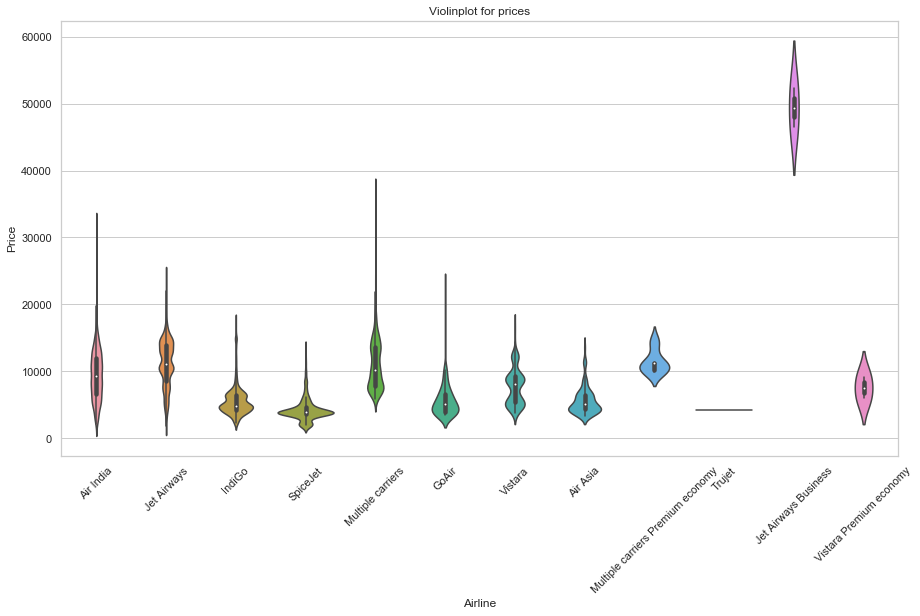

In [552]:
fig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="whitegrid")
violin = sns.violinplot(x="Airline", y="Price", data=data)
plt.xticks(rotation=45)
plt.title("Violinplot for prices")
plt.plot

#### Checking if Airline affects the price

In [553]:
z=data.groupby(['Airline'])['Price'].mean()
xx=list(z)

In [554]:
g=list(data.Airline.unique())

In [555]:
g.sort()
print(g)

['Air Asia', 'Air India', 'GoAir', 'IndiGo', 'Jet Airways', 'Jet Airways Business', 'Multiple carriers', 'Multiple carriers Premium economy', 'SpiceJet', 'Trujet', 'Vistara', 'Vistara Premium economy']


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

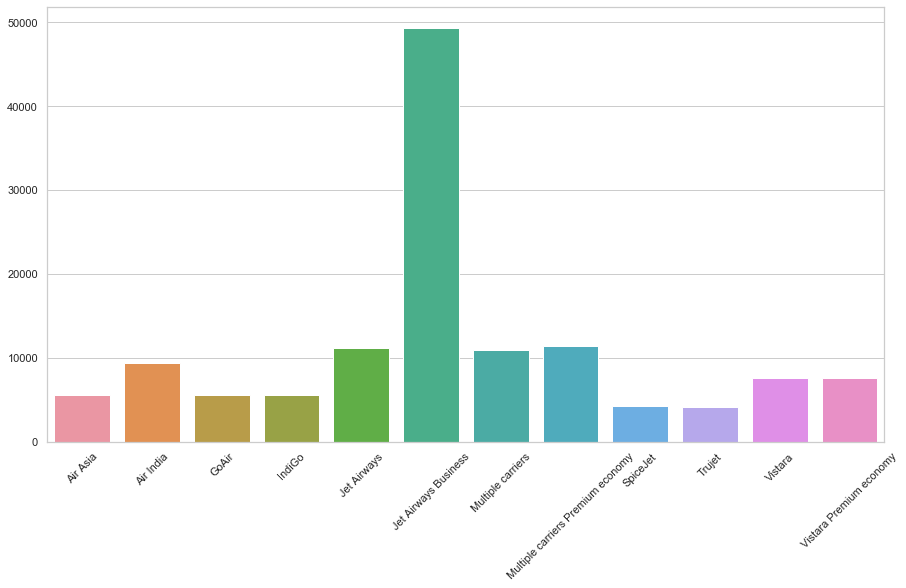

In [556]:
fig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="whitegrid")
ax = sns.barplot(x=g, y=xx,ax=ax)
plt.xticks(rotation=45)
plt.plot

#### Removing Jet Airways Business

In [557]:
indexNames1 = data[data['Airline'] == "Jet Airways Business" ].index

data.drop(indexNames1 , inplace=True)

#### Checking if Source affects the price

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

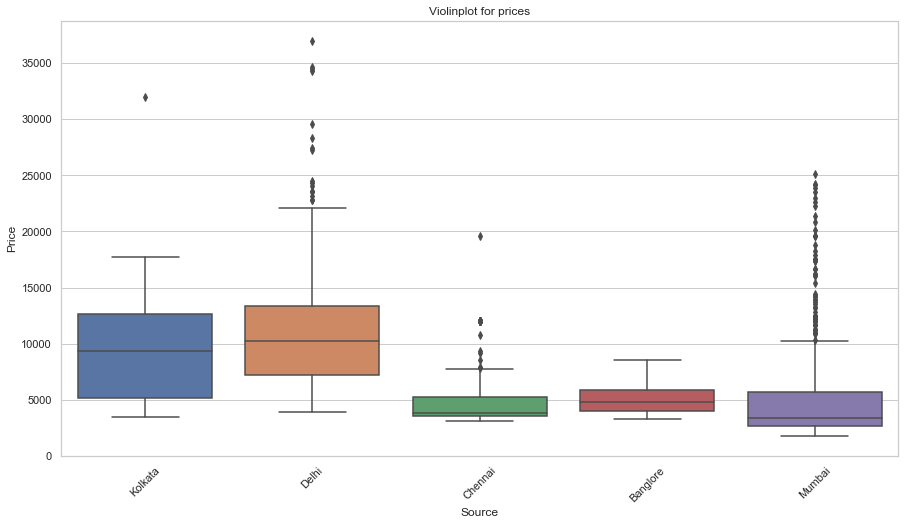

In [558]:
ig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="whitegrid")
violin = sns.boxplot(x="Source", y="Price", data=data)
plt.xticks(rotation=45)
plt.title("Violinplot for prices")
plt.plot

#### Checking if total stops affect the price

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

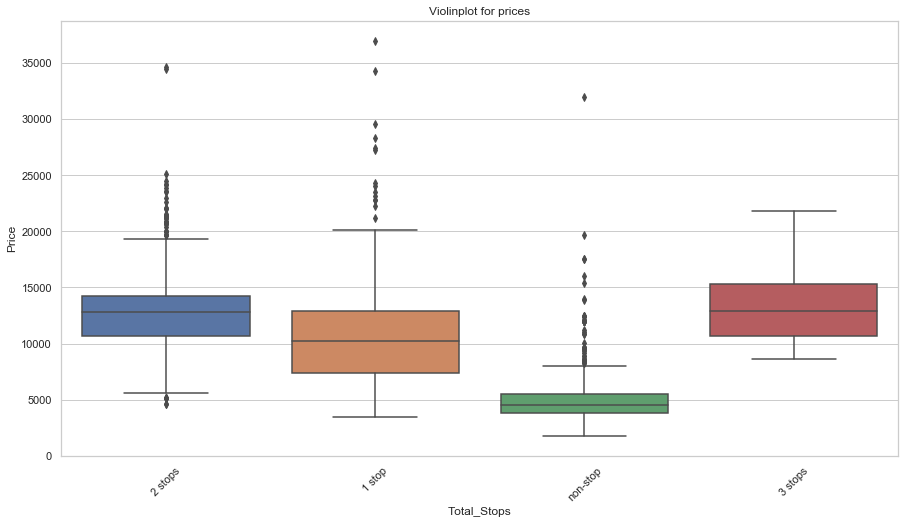

In [559]:
ig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="whitegrid")
violin = sns.boxplot(x="Total_Stops", y="Price", data=data)
plt.xticks(rotation=45)
plt.title("Violinplot for prices")
plt.plot

#### converting

In [560]:
data["day_of_journey"]=pd.to_datetime(data["Date_of_Journey"],format="%d/%m/%Y").dt.day
data["month_of_journey"]=pd.to_datetime(data["Date_of_Journey"],format="%d/%m/%Y").dt.month

In [561]:
data.drop(["Date_of_Journey"],axis=1,inplace=True)

In [562]:
data["dep_hour"]=pd.to_datetime(data["Dep_Time"]).dt.hour
data["dep_min"]=pd.to_datetime(data["Dep_Time"]).dt.minute

In [563]:
data.drop(["Dep_Time"],axis=1,inplace=True)

In [564]:
data["arr_hour"]=pd.to_datetime(data["Arrival_Time"]).dt.hour
data["arr_min"]=pd.to_datetime(data["Arrival_Time"]).dt.minute
data.drop(["Arrival_Time"],axis=1,inplace=True)

In [565]:
duration = list(data["Duration"])
def total(a):
    for i in range(len(a)):
        if len(a[i].split()) != 2:   
            if "h" in a[i]:
                a[i] = a[i].strip() + " 0m"   
            else:
                a[i] = "0h " + a[i]           

    duration_hours = []
    duration_mins = []
    for i in range(len(a)):
        duration_hours.append(int(a[i].split(sep = "h")[0]))    
        duration_mins.append(int(a[i].split(sep = "m")[0].split()[-1]))   
    total_time=[]
    for i in range(len(duration_hours)):
        total_time.append(((duration_hours[i])*60)+duration_mins[i])   
    return total_time 

In [566]:
total_time=total(duration)
data["total_time"]=total_time
data.drop(["Duration"],axis=1,inplace=True)

In [567]:
data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,day_of_journey,month_of_journey,dep_hour,dep_min,arr_hour,arr_min,total_time
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,445
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,1140
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,325
5,SpiceJet,Kolkata,Banglore,CCU → BLR,non-stop,No info,3873,24,6,9,0,11,25,145
9,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,1 stop,No info,8625,27,5,11,25,19,15,470


#### dropping additional info and route

In [568]:
data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

#### featurising total stops

In [569]:
data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

#### featurising Airline

In [570]:
air_train = data[["Airline"]]
air_train = pd.get_dummies(air_train, drop_first = True)
data.drop(["Airline"],axis=1,inplace=True)

In [571]:
air_train.shape

(9748, 10)

#### featurising source

In [572]:
source_train = data[["Source"]]
source_train = pd.get_dummies(source_train, drop_first = True)
data.drop(["Source"],axis=1,inplace=True)           

In [573]:
data.shape

(9748, 10)

#### featurusing destination

In [574]:
dest_train = data[["Destination"]]
dest_train = pd.get_dummies(dest_train,drop_first = True)
data.drop(["Destination"],axis=1,inplace=True)

In [575]:
dest_train.shape

(9748, 4)

#### Merging

In [576]:
x_tr=pd.concat([data, air_train, source_train, dest_train], axis = 1)

In [577]:
y = x_tr['Price'].values #seperating the features
X = x_tr.drop(['Price'], axis=1)

In [578]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.1,random_state=42) 

In [579]:
X_cv.shape

(975, 26)

#### Model 1--KNN

##### Hyperparameter tuning

In [580]:
knnparams = {'n_neighbors':[7,10,12,15,20,20],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}

In [581]:
model1=KNeighborsRegressor()

In [582]:
knnrand = RandomizedSearchCV(estimator=model1, param_distributions=knnparams,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [583]:
knnrand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto, total=  12.6s
[CV] weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s remaining:    0.0s


[CV]  weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto, total=   0.2s
[CV] weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto 
[CV]  weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto, total=   0.2s
[CV] weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto 
[CV]  weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto, total=   0.2s
[CV] weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto 
[CV]  weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto, total=   0.2s
[CV] weights=uniform, n_neighbors=12, n_jobs=-1, leaf_size=5, algorithm=kd_tree 
[CV]  weights=uniform, n_neighbors=12, n_jobs=-1, leaf_size=5, algorithm=kd_tree, total=   0.2s
[CV] weights=uniform, n_neighbors=12, n_jobs=-1, leaf_size=5, algorithm=kd_tree 
[CV]  weights=uniform, n_neighbors=12, n_jobs=-1, leaf_size=5, algorithm=kd_tree, total=   0.2s
[CV] weights=uniform, n_neighbors

[CV]  weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=1, algorithm=auto, total=   0.3s
[CV] weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=1, algorithm=auto 
[CV]  weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=1, algorithm=auto, total=   0.3s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   28.9s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                                 metric='minkowski',
                                                 metric_params=None,
                                                 n_jobs=None, n_neighbors=5,
                                                 p=2, weights='uniform'),
                   iid='deprecated', n_iter=10, n_jobs=1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [1, 2, 3, 5],
                                        'n_jobs': [-1],
                                        'n_neighbors': [7, 10, 12, 15, 20, 20],
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_t

In [584]:
knnrand.best_params_

{'weights': 'uniform',
 'n_neighbors': 12,
 'n_jobs': -1,
 'leaf_size': 2,
 'algorithm': 'auto'}

In [585]:
knnclf=KNeighborsRegressor(n_neighbors=10,weights='distance',n_jobs= -1,leaf_size=2,algorithm='auto')
knnclf.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                    weights='distance')

In [586]:
knnpred=knnclf.predict(X_cv)

In [587]:
print('MAE:', metrics.mean_absolute_error(y_cv, knnpred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_cv, knnpred)))

MAE: 1820.235974358123
RMSE: 2681.4467189503225


#### Model 2--Random forest

##### Hyperparameter tuning

In [588]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

rfmodel= RandomForestRegressor()

In [589]:
rfparam = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [590]:
rfrand = RandomizedSearchCV(estimator = rfmodel, param_distributions=rfparam,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [591]:
rfrand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   7.9s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   7.0s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   5.7s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   6.2s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   6.1s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   9.9s
[CV] n_estimators=1100, min_samples_split=10, mi

[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   2.9s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   3.0s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   2.5s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   2.5s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   2.9s
[CV] n_estimators=700, min_samples_split=15, min_sam

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  6.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [592]:
rfrand.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [593]:
rfclf=RandomForestRegressor(n_estimators=700,max_depth=20,min_samples_split=15,min_samples_leaf=1,max_features="auto")
rfclf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=15, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [594]:
rfpred=rfclf.predict(X_cv)

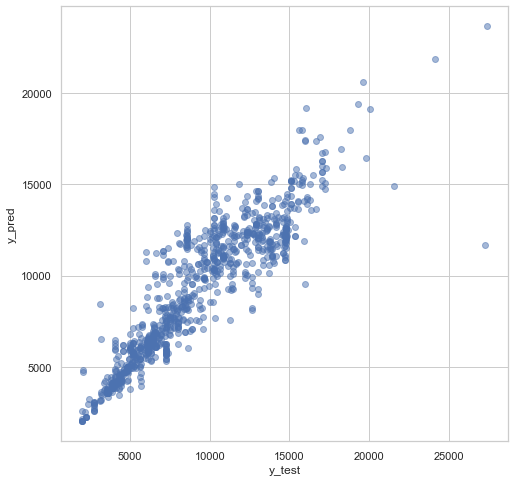

In [595]:
plt.figure(figsize = (8,8))
plt.scatter(y_cv, rfpred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [596]:
print('MAE:', metrics.mean_absolute_error(y_cv, rfpred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_cv, rfpred)))

MAE: 1076.1605911623883
RMSE: 1615.6760229503016


#### Model 3-GBDT

In [597]:
gbmodel=GradientBoostingRegressor()

In [598]:
max_features = list(range(1,x_tr.shape[1]))
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
max_depths = np.linspace(1, 32, 32, endpoint=True)
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]

In [599]:
gbparam={'learning_rate':learning_rates,
        'n_estimators':n_estimators ,
        'max_depth':max_depths,
        'min_samples_split':min_samples_splits,
       'min_samples_leaf':min_samples_leafs,
        'max_features':max_features}

In [600]:
gbrand = RandomizedSearchCV(estimator = gbmodel, param_distributions=gbparam,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [601]:
gbrand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=100, min_samples_split=0.8, min_samples_leaf=0.2, max_features=18, max_depth=30.0, learning_rate=0.01 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, min_samples_split=0.8, min_samples_leaf=0.2, max_features=18, max_depth=30.0, learning_rate=0.01, total=   0.5s
[CV] n_estimators=100, min_samples_split=0.8, min_samples_leaf=0.2, max_features=18, max_depth=30.0, learning_rate=0.01 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=0.8, min_samples_leaf=0.2, max_features=18, max_depth=30.0, learning_rate=0.01, total=   0.3s
[CV] n_estimators=100, min_samples_split=0.8, min_samples_leaf=0.2, max_features=18, max_depth=30.0, learning_rate=0.01 
[CV]  n_estimators=100, min_samples_split=0.8, min_samples_leaf=0.2, max_features=18, max_depth=30.0, learning_rate=0.01, total=   0.3s
[CV] n_estimators=100, min_samples_split=0.8, min_samples_leaf=0.2, max_features=18, max_depth=30.0, learning_rate=0.01 
[CV]  n_estimators=100, min_samples_split=0.8, min_samples_leaf=0.2, max_features=18, max_depth=30.0, learning_rate=0.01, total=   0.3s
[CV] n_estimators=100, min_samples_split=0.8, min_samples_leaf=0.2, max_features=18, max_depth=30.0, learning_rate=0.01 
[CV]  n_estimators=100, min_samples_split=0.8, min_samples_leaf=0.2, max_features=18, max_depth=30.0, learning_rate=0.01, total=   0.3s
[CV] n_estimators=1, min_samples_split=0.7000000000000001, min_samples_leaf=0.300000000000000

[CV]  n_estimators=2, min_samples_split=0.6, min_samples_leaf=0.5, max_features=5, max_depth=7.0, learning_rate=0.05, total=   0.0s
[CV] n_estimators=1, min_samples_split=0.7000000000000001, min_samples_leaf=0.4, max_features=6, max_depth=12.0, learning_rate=0.01 
[CV]  n_estimators=1, min_samples_split=0.7000000000000001, min_samples_leaf=0.4, max_features=6, max_depth=12.0, learning_rate=0.01, total=   0.0s
[CV] n_estimators=1, min_samples_split=0.7000000000000001, min_samples_leaf=0.4, max_features=6, max_depth=12.0, learning_rate=0.01 
[CV]  n_estimators=1, min_samples_split=0.7000000000000001, min_samples_leaf=0.4, max_features=6, max_depth=12.0, learning_rate=0.01, total=   0.0s
[CV] n_estimators=1, min_samples_split=0.7000000000000001, min_samples_leaf=0.4, max_features=6, max_depth=12.0, learning_rate=0.01 
[CV]  n_estimators=1, min_samples_split=0.7000000000000001, min_samples_leaf=0.4, max_features=6, max_depth=12.0, learning_rate=0.01, total=   0.0s
[CV] n_estimators=1, min_

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.8s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                             

In [602]:
gbrand.best_params_

{'n_estimators': 8,
 'min_samples_split': 0.4,
 'min_samples_leaf': 0.1,
 'max_features': 16,
 'max_depth': 31.0,
 'learning_rate': 0.5}

In [603]:
gbclf=gbmodel=GradientBoostingRegressor(n_estimators= 8,min_samples_split=0.4,min_samples_leaf= 0.1,max_features=16,max_depth=31.0,learning_rate=0.5)

In [604]:
gbclf.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.5, loss='ls',
                          max_depth=25.0, max_features=4, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=0.1, min_samples_split=0.4,
                          min_weight_fraction_leaf=0.0, n_estimators=8,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [605]:
gbpred=gbclf.predict(X_cv)

In [606]:
print('MAE:', metrics.mean_absolute_error(y_cv, gbpred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_cv, gbpred)))

MAE: 1968.2150538273875
RMSE: 2604.9452682534197


#### Summary

In [607]:
tb = PrettyTable()
tb.field_names = [ "Model", 'MAE','RMSE' ]
tb.add_row(["KNN",round(metrics.mean_absolute_error(y_cv, knnpred),2),round(np.sqrt(metrics.mean_squared_error(y_cv, knnpred)),2)])
tb.add_row(["RandomForest",round(metrics.mean_absolute_error(y_cv, rfpred),2),round(np.sqrt(metrics.mean_squared_error(y_cv, rfpred)),2)])
tb.add_row(["GBDT",round(metrics.mean_absolute_error(y_cv, gbpred),2),round(np.sqrt(metrics.mean_squared_error(y_cv, gbpred)),2)])

print(tb)

+--------------+---------+---------+
|    Model     |   MAE   |   RMSE  |
+--------------+---------+---------+
|     KNN      | 1820.24 | 2681.45 |
| RandomForest | 1076.16 | 1615.68 |
|     GBDT     | 1968.22 | 2604.95 |
+--------------+---------+---------+


In [608]:
'''
import pickle
file = open('flight.pkl', 'wb')
pickle.dump(rfclf, file)
'''

"\nimport pickle\nfile = open('randomforest4.pkl', 'wb')\npickle.dump(rfclf, file)\n"